# Import images from the mnist pickle #

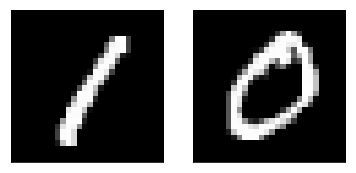

In [3]:
import numpy as np
import os
import pickle
from itertools import count
import matplotlib.pyplot as plt


with open('mnist.pkl', 'rb') as mnist_pickle:
    mnist = pickle.load(mnist_pickle, encoding='bytes')
    
mnist['data'] = mnist['data'].astype(np.float32) # convert the uint8s to floats
mnist['data'] /= 255 # scale to be from 0 to 1
mnist['target'] = mnist['target'].astype(np.int32) # convert the uint8s to int32s

def set_mnist_pos_neg(positive_label, negative_label):
    positive_indices = [i for i, j in zip(count(), mnist['target']) if j == positive_label]
    negative_indices = [i for i, j in zip(count(), mnist['target']) if j == negative_label]

    positive_images = mnist['data'][positive_indices]
    negative_images = mnist['data'][negative_indices]

    fig = plt.figure()
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(positive_images[0].reshape(28,28), cmap='gray', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(negative_images[0].reshape(28,28), cmap='gray', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
    
    return positive_images, negative_images

positive_images, negative_images = set_mnist_pos_neg(1, 0)


In [6]:
def print_image_size_info(images):
    print("There are {0} images, each of shape {1} x {2}".format(images.shape[0],images.shape[1]**0.5,images.shape[1]**0.5))
    
print_image_size_info(positive_images)
print_image_size_info(negative_images)

There are 7877 images, each of shape 28.0 x 28.0
There are 6903 images, each of shape 28.0 x 28.0


# Define the Network #

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable



class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 4 * 4, 120)     #Remember to change this based on the input layer dimensions!
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net (
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear (256 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 10)
)


# Print number of learnable parameters # 

In [41]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

10
torch.Size([6, 1, 5, 5])


##### Use this code block instead if working with pytorch > 0.4

<code>
input = torch.randn(1,1,32,32)

output = net(input)
target = torch.arange(1, 11)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)
</code>

In [76]:
from torch.autograd import Variable

input = Variable(torch.randn(10, 1, 28, 28))

output = net(input)
target = Variable(torch.arange(1, 11))  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
target = target.long()

print(target)

criterion = nn.CrossEntropyLoss()

loss = criterion(output, target)
print(loss)

Variable containing:
    1     2     3     4     5     6     7     8     9    10
[torch.LongTensor of size 1x10]



RuntimeError: multi-target not supported at /opt/conda/conda-bld/pytorch_1501971235237/work/pytorch-0.1.12/torch/lib/THNN/generic/ClassNLLCriterion.c:20

In [43]:
net.zero_grad()

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
None
conv1.bias.grad after backward
Variable containing:
1.00000e-02 *
 -6.2949
 -7.9244
  5.6776
 -3.9522
  5.0499
 -9.4746
[torch.FloatTensor of size 6]



In [45]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

for epoch in range(500):

    # in your training loop:
    optimizer.zero_grad()   # zero the gradient buffers
    output = net(input)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()    # Does the update

print(epoch,loss)

499 Variable containing:
1.00000e-09 *
  2.0993
[torch.FloatTensor of size 1]



In [2]:
import torchvision

import torchvision.transforms as transforms


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

In [3]:
dataiter = iter(trainloader)

In [9]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [10]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        
        inputs,labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

RuntimeError: received 0 items of ancdata